<a href="https://colab.research.google.com/github/tomas-vl/aml-akcie/blob/main/aml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Načtení dat

In [ ]:
!wget https://raw.githubusercontent.com/tomas-vl/aml-akcie/main/data/ORCL_all.csv

--2024-04-09 14:11:18--  https://raw.githubusercontent.com/tomas-vl/aml-akcie/main/data/ORCL_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 709573 (693K) [text/plain]
Saving to: ‘ORCL_all.csv’

ORCL_all.csv        100%[===================>] 692.94K  --.-KB/s    in 0.02s   

2024-04-09 14:11:18 (38.1 MB/s) - ‘ORCL_all.csv’ saved [709573/709573]



In [ ]:
import pandas as pd

In [ ]:
all = pd.read_csv('ORCL_all.csv')
all = all.loc[all['date'] > '2015-01-01']
print(all)

split_date = '2021-01-01'

training = all.loc[all['date'] <= split_date]
test = all.loc[all['date'] > split_date]

print(training)
print(test)

      Unnamed: 0    id        date        open        high         low  \
7264        7265  7265  2015-01-02   45.020000   45.189999   43.970001   
7265        7266  7266  2015-01-05   44.160000   44.250000   43.580002   
7266        7267  7267  2015-01-06   44.060001   44.180000   42.990002   
7267        7268  7268  2015-01-07   43.330002   43.520000   43.009998   
7268        7269  7269  2015-01-08   43.630001   43.939999   43.380001   
...          ...   ...         ...         ...         ...         ...   
9580        9581  9581  2024-03-18  127.199997  128.949997  126.879997   
9581        9582  9582  2024-03-19  127.750000  129.210007  126.489998   
9582        9583  9583  2024-03-20  129.979996  130.690002  128.270004   
9583        9584  9584  2024-03-21  130.520004  132.770004  128.949997   
9584        9585  9585  2024-03-22  129.009995  129.210007  127.550003   

           close  adjusted_close    volume  
7264   44.330002       38.272781  15070200  
7265   43.590000     

# Lineárny model

Import ďalších knižníc

In [ ]:
# TA-lib download
# https://stackoverflow.com/a/49660479
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4075    0  4075    0     0   7442      0 --:--:-- --:--:-- --:--:--  7449
100  517k  100  517k    0     0   410k      0  0:00:01  0:00:01 --:--:-- 1847k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4087    0  4087    0     0  13953      0 --:--:-- --:--:-- --:--:-- 13996
100  392k  100  392k    0     0   337k      0  0:00:01  0:00:01 --:--:--  704k


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import talib

Adding 1-day percent changes to DataFrame

In [ ]:
#alldata_df = pd.DataFrame(data=all, columns=["date", "open", "high", "low", "close", "adjusted_close", "volume"])
#alldata_df = pd.read_csv('ORCL_all.csv')
alldata_df = all
print(alldata_df.head())

# Create 1-day % changes of Adj_Close for the current day, and 1 day in the future
alldata_df['1d_future_close'] = alldata_df['adjusted_close'].shift(-1)
alldata_df['1d_close_future_pct'] = alldata_df['1d_future_close'].pct_change(1, fill_method=None)
alldata_df['1d_close_pct'] = alldata_df['adjusted_close'].pct_change(1, fill_method=None)

print(alldata_df.head())

      Unnamed: 0    id        date       open       high        low  \
7264        7265  7265  2015-01-02  45.020000  45.189999  43.970001   
7265        7266  7266  2015-01-05  44.160000  44.250000  43.580002   
7266        7267  7267  2015-01-06  44.060001  44.180000  42.990002   
7267        7268  7268  2015-01-07  43.330002  43.520000  43.009998   
7268        7269  7269  2015-01-08  43.630001  43.939999  43.380001   

          close  adjusted_close    volume  1d_future_close  \
7264  44.330002       38.272781  15070200        37.736038   
7265  43.590000       37.736038  18369400        37.346478   
7266  43.139999       37.346478  19229500        37.355148   
7267  43.150002       37.355148  13502200        37.580227   
7268  43.410000       37.580227  17516900        37.562916   

      1d_close_future_pct  1d_close_pct  ma14  rsi14  ma30  rsi30  ma50  \
7264                  NaN           NaN   NaN    NaN   NaN    NaN   NaN   
7265            -0.010323     -0.014024   NaN    N

Features

In [ ]:
feature_names = ['1d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:
    # Create the moving average indicator and divide by Adj_Close
    alldata_df['ma' + str(n)] = talib.SMA(alldata_df['adjusted_close'].values,
                                      timeperiod=n) / alldata_df['adjusted_close']
    # Create the RSI indicator
    alldata_df['rsi' + str(n)] = talib.RSI(alldata_df['adjusted_close'].values, timeperiod=n)

    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
print(feature_names)

['1d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [ ]:
# Drop all na values
alldata_df = alldata_df.dropna()

Creating features and targets

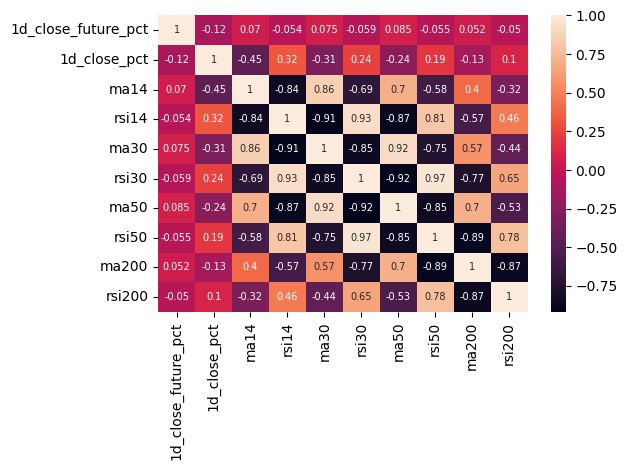

In [ ]:
# use feature_names for features; '1d_close_future_pct' for targets
features = alldata_df[feature_names]
targets = alldata_df['1d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['1d_close_future_pct'] + feature_names
feat_targ_df = alldata_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
#print(corr)

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot= True, annot_kws = {"size": 7})
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()

Creating a scatter plot of the most highly correlated variable (RSI50) with the target

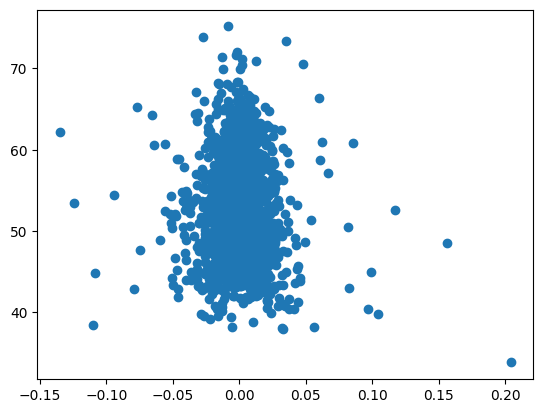

In [ ]:
plt.scatter(alldata_df['1d_close_future_pct'], alldata_df['rsi50']) #rsi30, ma50 and ma30 are also highly correlated
plt.show()

Creating a linear model with added features

In [ ]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = (int(0.85 * targets.shape[0]))
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

(2120, 10) (1802, 10) (318, 10)
                             OLS Regression Results                            
Dep. Variable:     1d_close_future_pct   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     6.857
Date:                 Tue, 09 Apr 2024   Prob (F-statistic):           9.44e-10
Time:                         15:46:21   Log-Likelihood:                 4808.4
No. Observations:                 1802   AIC:                            -9597.
Df Residuals:                     1792   BIC:                            -9542.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const 

Examining p-values

In [ ]:
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const           1.801104e-02
1d_close_pct    7.945231e-07
ma14            4.584547e-02
rsi14           6.282108e-03
ma30            4.177447e-01
rsi30           6.758295e-02
ma50            7.105855e-02
rsi50           7.884227e-02
ma200           8.294611e-01
rsi200          2.018894e-02
dtype: float64


Making and visualizing predictions

7464    0.003322
7465    0.001636
7466    0.002245
7467   -0.001771
7468    0.001460
          ...   
9261   -0.003576
9262   -0.005703
9263   -0.002954
9264   -0.005351
9265   -0.001759
Length: 1802, dtype: float64


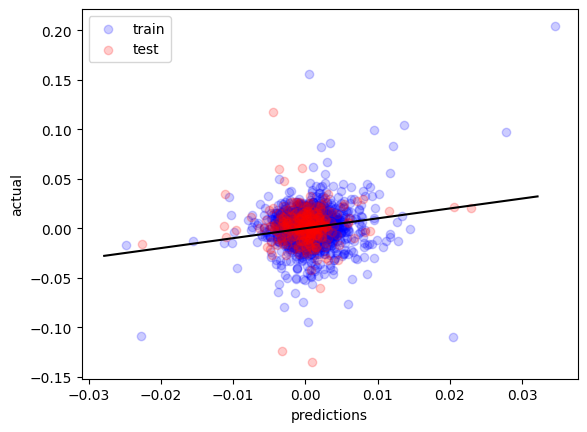

In [ ]:
# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)
print(train_predictions)

# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()


*Zatiaľ nevydarený pokus o vizualizáciu ziskov*

      1d_close_pct
7464     -0.013380
7465     -0.000271
7466     -0.006511
7467      0.031950
7468      0.007409
...            ...
9579      0.000080
9580      0.018002
9581      0.010876
9582      0.000387
9583     -0.001780

[2120 rows x 1 columns] 9266   -0.004937
9267   -0.000070
9268   -0.001914
9269   -0.004021
9270   -0.003113
          ...   
9579   -0.005037
9580   -0.007595
9581   -0.006461
9582   -0.004317
9583   -0.003368
Length: 318, dtype: float64
9266    0.0
9267    0.0
9268    0.0
9269    0.0
9270    0.0
       ... 
9579    0.0
9580    0.0
9581    0.0
9582    0.0
9583    0.0
Length: 318, dtype: float64


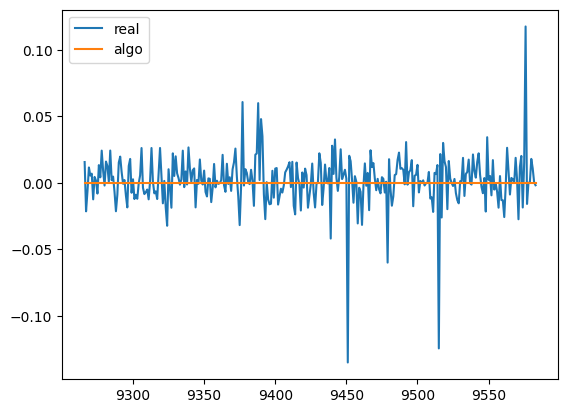

In [ ]:
returns_daily = pd.DataFrame(data=alldata_df, columns=['1d_close_pct'])
print(returns_daily, test_predictions)
test_returns = np.sum(returns_daily.iloc[train_size:] * test_predictions, axis=1)
print(test_returns) #netuším, prečo nám to tu vracia nulu
plt.plot(returns_daily.iloc[train_size:], label="real")
plt.plot(test_returns, label='algo')
plt.legend()
plt.show()